In [ ]:
pip install dash

  Using cached dash-2.18.1-py3-none-any.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 44.2 MB/s eta 0:00:00


Loading network traffic data...

Initializing Enhanced IDS system...

Generating network traffic visualizations...


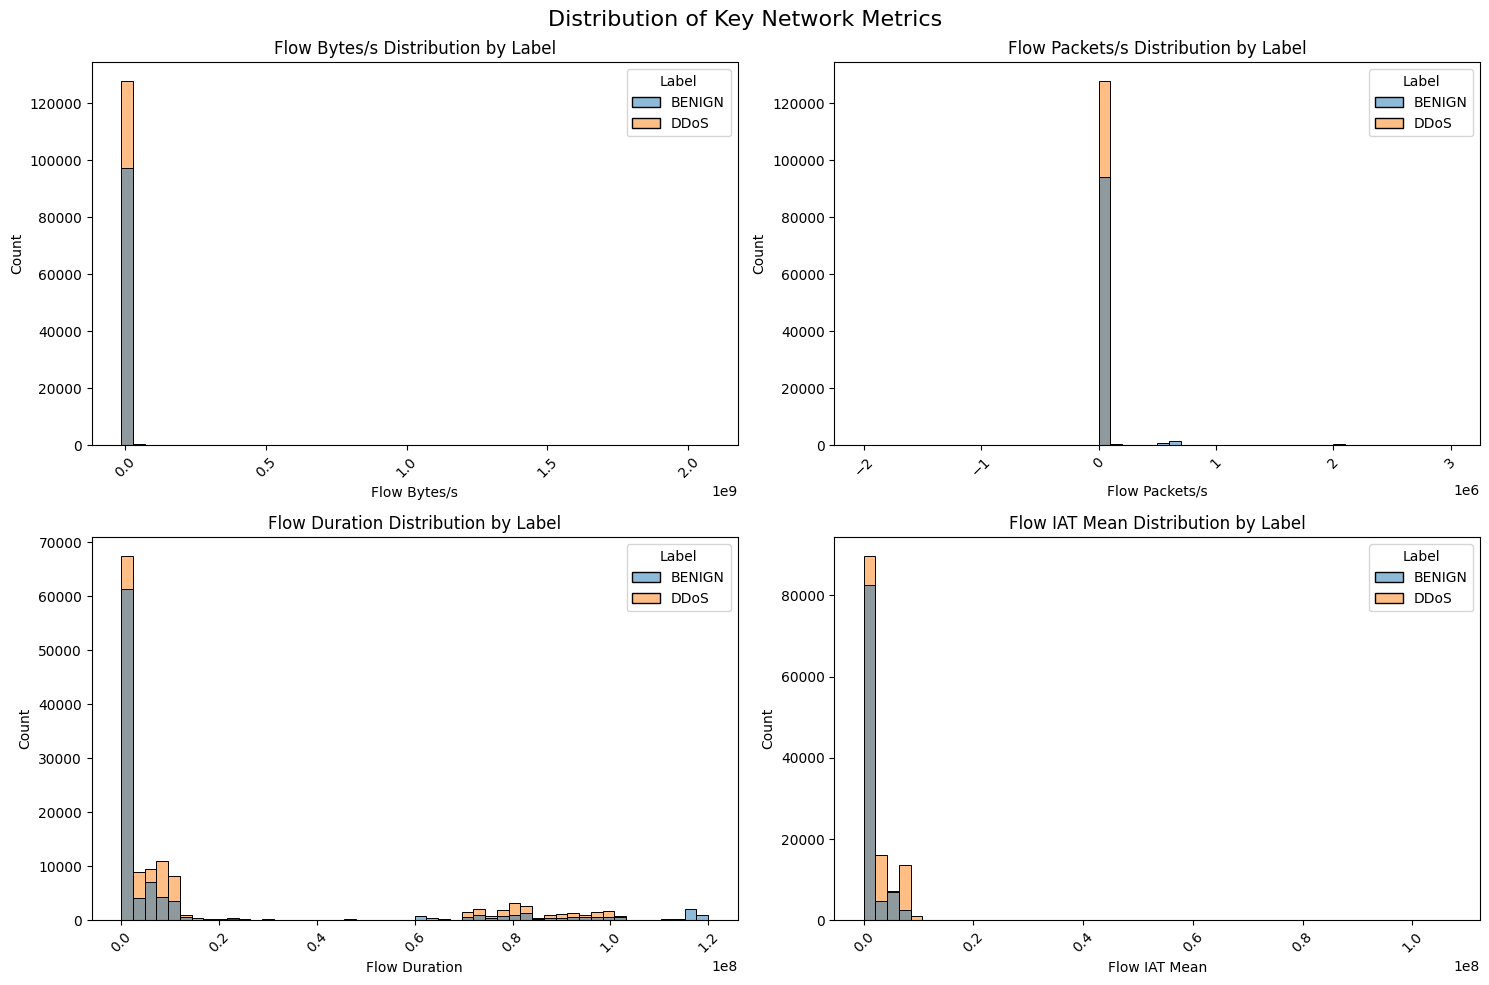

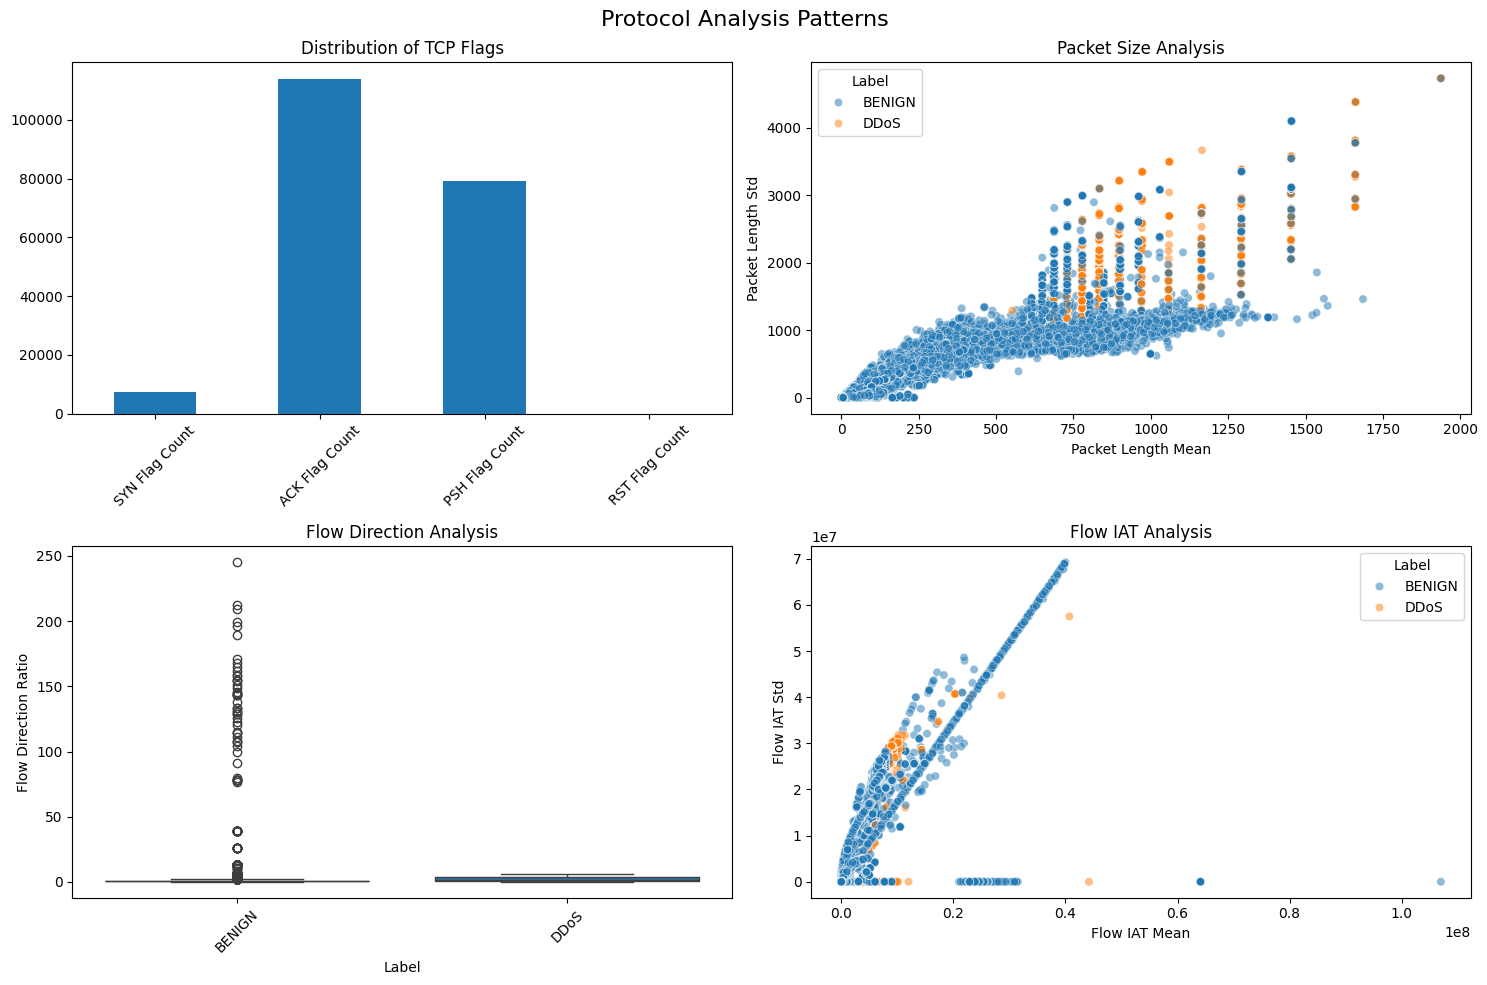

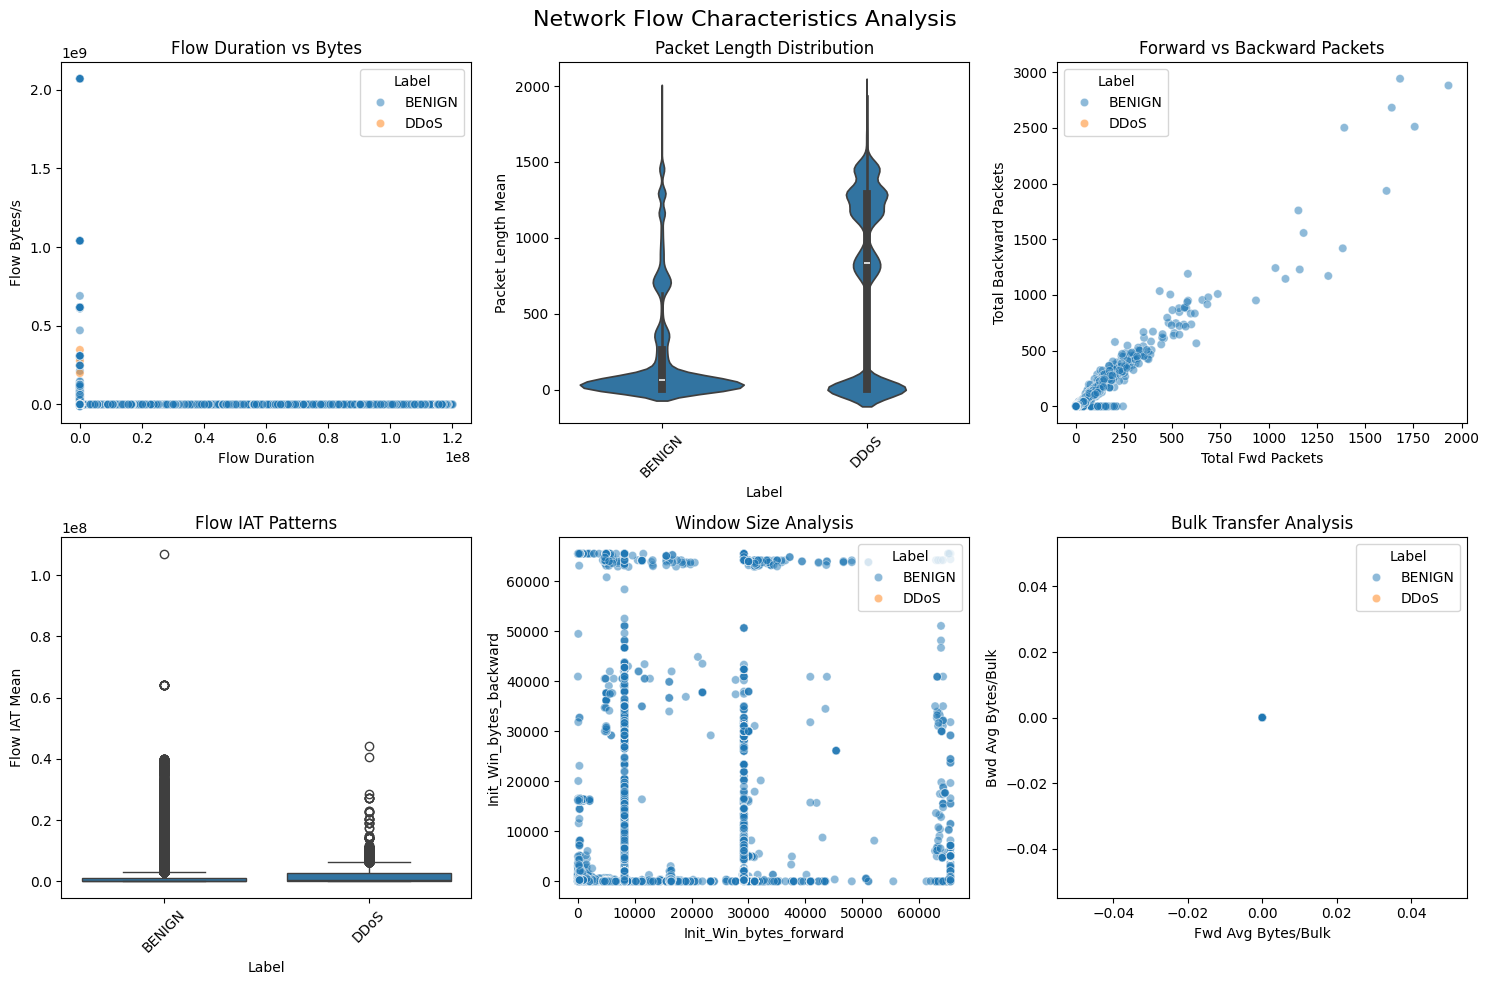

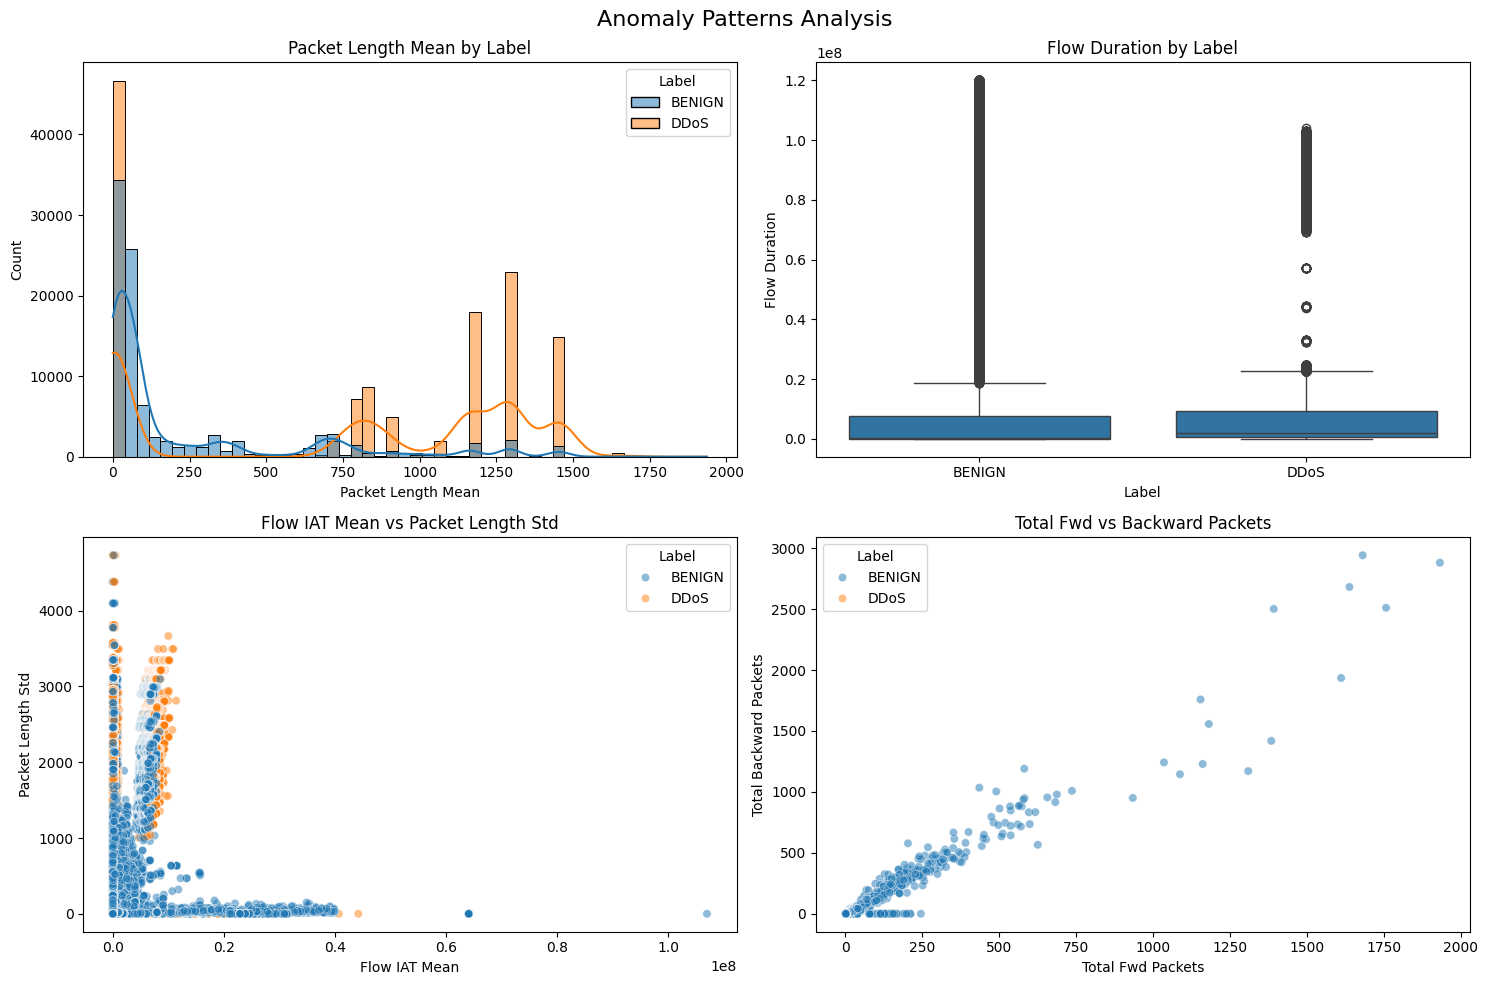


Preprocessing data...
Encoding labels...

Splitting data into training and test sets...

Performing feature selection...
Selected features:
1. Fwd Header Length
2. Fwd Header Length.1
3. Fwd Packet Length Max
4. Subflow Fwd Bytes
5. Fwd Packet Length Mean
6. Total Length of Fwd Packets
7. Destination Port
8. Avg Fwd Segment Size
9. Fwd IAT Total
10. Init_Win_bytes_forward
11. Fwd IAT Max

Training enhanced IDS model...
RandomForest ensemble model initialized.
Model training complete.

Visualizing feature selection results...


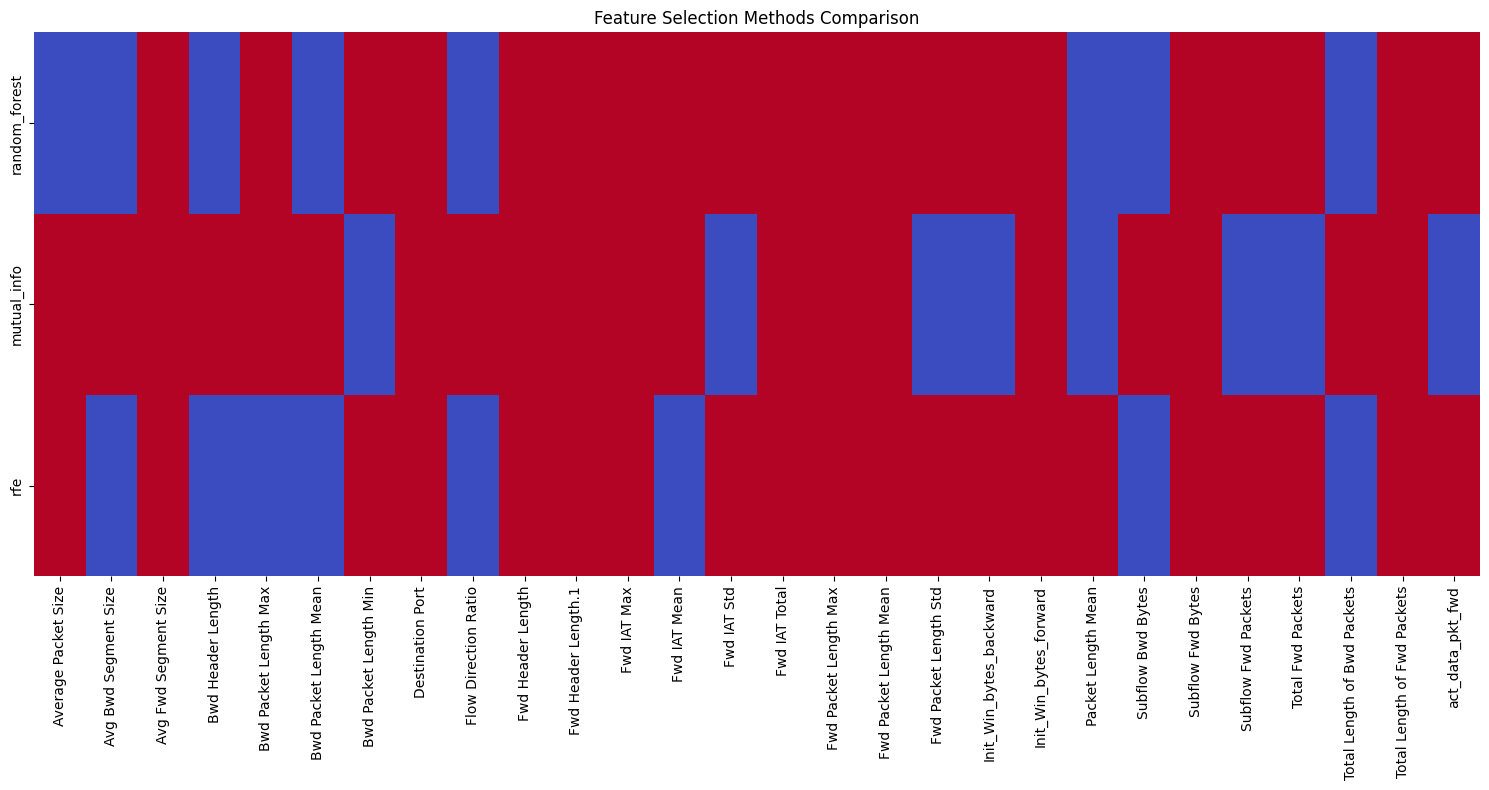


Evaluating enhanced model performance...
Model Accuracy: 99.97%
Feature importance analysis:
Fwd Packet Length Max          0.210734
Avg Fwd Segment Size           0.158692
Subflow Fwd Bytes              0.116437
Fwd Packet Length Mean         0.112001
Total Length of Fwd Packets    0.086804
Init_Win_bytes_forward         0.068927
Fwd Header Length.1            0.060433
Destination Port               0.052564
Fwd IAT Total                  0.049377
Fwd IAT Max                    0.044284
Fwd Header Length              0.039747
dtype: float64
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19544
           1       1.00      1.00      1.00     25605

    accuracy                           1.00     45149
   macro avg       1.00      1.00      1.00     45149
weighted avg       1.00      1.00      1.00     45149



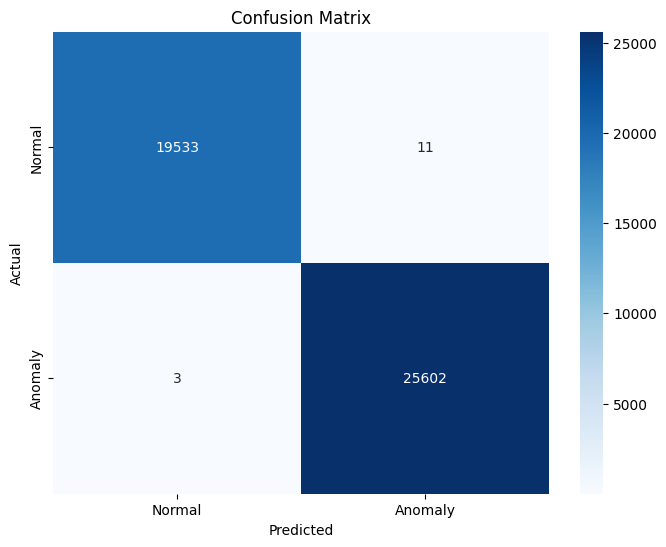


Saving enhanced model...
Model saved to enhanced_ids_model_v2.pkl
Enhanced model saved successfully!

Testing ImprovedIDS capabilities...

Preparing improved model...
RandomForest ensemble model initialized.
Model training complete.

Performing time-based validation...
RandomForest ensemble model initialized.
Model training complete.
RandomForest ensemble model initialized.
Model training complete.
RandomForest ensemble model initialized.
Model training complete.
RandomForest ensemble model initialized.
Model training complete.
RandomForest ensemble model initialized.
Model training complete.

Time-based validation results:
   precision  recall      f1 support
0     0.9996  0.9996  0.9996    None
1     0.9998  0.9998  0.9998    None
2     0.9998  0.9998  0.9998    None
3     0.9999  0.9999  0.9999    None
4     0.9982  0.9982  0.9982    None

Analyzing threshold sensitivity...

Threshold sensitivity results:
   threshold  precision  recall      f1
0        0.1     0.9990  0.9990  0.99

In [ ]:
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel, mutual_info_classif, RFE
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import networkx as nx
from scipy.stats import zscore
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


class EnhancedIDS:
    def __init__(self):
        self.scalers = {}
        self.label_encoders = {}
        self.model = None
        self.feature_importance = None
        self.selected_features = None
        self.feature_rankings = None

    def preprocess_data(self, X):
        """
        Preprocess data by handling missing, infinite, and extremely large values,
        followed by scaling.
        """
        # Replace infinite values and large values
        X = X.replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
        X = X.fillna(X.mean())  # Fill NaN values with the mean of each column

        # Optionally, cap large values if needed (e.g., replace values > 1e10)
        X = X.clip(upper=1e10)

        # Standard scaling
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

        return X

    def save_model(self, filepath):
        """
        Save the trained model to the specified file path.
        """
        with open(filepath, 'wb') as f:
            joblib.dump(self.model, f)
        print(f"Model saved to {filepath}")

    def handle_imbalance(self, X, y):
        """
        Balances the dataset by oversampling the minority class using SMOTE.
        """
        smote = SMOTE(random_state=42)
        X_balanced, y_balanced = smote.fit_resample(X, y)
        print("Data balanced using SMOTE. New class distribution:")
        print(pd.Series(y_balanced).value_counts())
        return X_balanced, y_balanced

    def build_ensemble_model(self):
        """
        Builds an ensemble model for intrusion detection, using Random Forest.
        """
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        print("RandomForest ensemble model initialized.")
        return model

    def select_features(self, X, y, n_features=20):
        """
        Comprehensive feature selection using multiple methods
        """
        # Random Forest importance-based selection
        rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
        rf_selector.fit(X, y)
        rf_important = X.columns[rf_selector.get_support()].tolist()

        # Mutual Information selection
        mi_scores = mutual_info_classif(X, y)
        mi_important = X.columns[np.argsort(mi_scores)[-n_features:]].tolist()

        # Recursive Feature Elimination
        rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42),
                  n_features_to_select=n_features)
        rfe.fit(X, y)
        rfe_important = X.columns[rfe.support_].tolist()

        # Combine results
        self.feature_rankings = {
            'random_forest': rf_important,
            'mutual_info': mi_important,
            'rfe': rfe_important
        }

        # Get intersection of all methods
        self.selected_features = list(set(rf_important) & set(mi_important) & set(rfe_important))
        return self.selected_features

    def plot_network_metrics_distribution(self, df):
        """
        Plot distribution of key network metrics
        """
        metrics = ['Flow Bytes/s', 'Flow Packets/s', 'Flow Duration', 'Flow IAT Mean']
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Distribution of Key Network Metrics', fontsize=16)

        for idx, metric in enumerate(metrics):
            row = idx // 2
            col = idx % 2
            sns.histplot(data=df, x=metric, hue='Label', ax=axes[row, col], bins=50)
            axes[row, col].set_title(f'{metric} Distribution by Label')
            axes[row, col].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    def plot_protocol_analysis(self, df):
        """
        Visualize protocol-related patterns
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Protocol Analysis Patterns', fontsize=16)

        # Flag counts
        flag_cols = ['SYN Flag Count', 'ACK Flag Count', 'PSH Flag Count', 'RST Flag Count']
        df[flag_cols].sum().plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('Distribution of TCP Flags')
        axes[0,0].tick_params(axis='x', rotation=45)

        # Packet size analysis
        sns.scatterplot(data=df, x='Packet Length Mean', y='Packet Length Std',
                       hue='Label', ax=axes[0,1], alpha=0.5)
        axes[0,1].set_title('Packet Size Analysis')

        # Flow direction analysis
        df['Flow Direction Ratio'] = df['Total Fwd Packets'] / (df['Total Backward Packets'] + 1)
        sns.boxplot(data=df, y='Flow Direction Ratio', x='Label', ax=axes[1,0])
        axes[1,0].set_title('Flow Direction Analysis')
        axes[1,0].tick_params(axis='x', rotation=45)

        # IAT (Inter-Arrival Time) analysis
        sns.scatterplot(data=df, x='Flow IAT Mean', y='Flow IAT Std',
                       hue='Label', ax=axes[1,1], alpha=0.5)
        axes[1,1].set_title('Flow IAT Analysis')

        plt.tight_layout()
        plt.show()

    def visualize_feature_selection_results(self):
        """
        Visualize feature selection results from different methods
        """
        if not self.feature_rankings:
            raise ValueError("Feature selection must be performed first")

        # Create comparison plot
        plt.figure(figsize=(15, 8))
        methods = list(self.feature_rankings.keys())
        feature_sets = list(self.feature_rankings.values())

        # Create binary matrix of feature selection results
        all_features = sorted(list(set().union(*feature_sets)))
        matrix = np.zeros((len(methods), len(all_features)))

        for i, method_features in enumerate(feature_sets):
            for j, feature in enumerate(all_features):
                if feature in method_features:
                    matrix[i, j] = 1

        # Plot heatmap
        sns.heatmap(matrix, xticklabels=all_features, yticklabels=methods,
                   cmap='coolwarm', cbar=False)
        plt.title('Feature Selection Methods Comparison')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    def plot_flow_characteristics(self, df):
        """
        Visualize flow characteristics and patterns
        """
        fig = plt.figure(figsize=(15, 10))
        gs = fig.add_gridspec(2, 3)
        fig.suptitle('Network Flow Characteristics Analysis', fontsize=16)

        # Flow duration vs bytes
        ax1 = fig.add_subplot(gs[0, 0])
        sns.scatterplot(data=df, x='Flow Duration', y='Flow Bytes/s',
                       hue='Label', alpha=0.5, ax=ax1)
        ax1.set_title('Flow Duration vs Bytes')

        # Packet length distribution
        ax2 = fig.add_subplot(gs[0, 1])
        sns.violinplot(data=df, y='Packet Length Mean', x='Label', ax=ax2)
        ax2.set_title('Packet Length Distribution')
        ax2.tick_params(axis='x', rotation=45)

        # Forward vs Backward packets
        ax3 = fig.add_subplot(gs[0, 2])
        sns.scatterplot(data=df, x='Total Fwd Packets', y='Total Backward Packets',
                       hue='Label', alpha=0.5, ax=ax3)
        ax3.set_title('Forward vs Backward Packets')

        # IAT patterns
        ax4 = fig.add_subplot(gs[1, 0])
        sns.boxplot(data=df, y='Flow IAT Mean', x='Label', ax=ax4)
        ax4.set_title('Flow IAT Patterns')
        ax4.tick_params(axis='x', rotation=45)

        # Window size analysis
        ax5 = fig.add_subplot(gs[1, 1])
        sns.scatterplot(data=df, x='Init_Win_bytes_forward',
                       y='Init_Win_bytes_backward',
                       hue='Label', alpha=0.5, ax=ax5)
        ax5.set_title('Window Size Analysis')

        # Bulk transfer analysis
        ax6 = fig.add_subplot(gs[1, 2])
        sns.scatterplot(data=df, x='Fwd Avg Bytes/Bulk',
                       y='Bwd Avg Bytes/Bulk',
                       hue='Label', alpha=0.5, ax=ax6)
        ax6.set_title('Bulk Transfer Analysis')

        plt.tight_layout()
        plt.show()

    def train(self, X_train, y_train):
        """
        Trains the model on the provided data.
        """
        self.model = self.build_ensemble_model()
        self.model.fit(X_train[self.selected_features], y_train)
        print("Model training complete.")

    def evaluate(self, X_test, y_test):
        """
        Evaluates the model's performance and analyzes feature importance.
        """
        # Ensure only selected features are used in X_test
        X_test_selected = X_test[self.selected_features]

        predictions = self.model.predict(X_test_selected)
        accuracy = accuracy_score(y_test, predictions)
        print(f"Model Accuracy: {accuracy * 100:.2f}%")

        # Feature importance analysis for RandomForest
        if hasattr(self.model, 'feature_importances_'):
            self.feature_importance = pd.Series(
                self.model.feature_importances_,
                index=X_test_selected.columns
            ).sort_values(ascending=False)

            print("Feature importance analysis:")
            print(self.feature_importance)
        else:
            print("The model does not support feature importance analysis.")

        # Generate classification report
        print("Classification Report:")
        print(classification_report(y_test, predictions))

        # Confusion matrix
        cm = confusion_matrix(y_test, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    def plot_anomaly_patterns(self, df):
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Anomaly Patterns Analysis', fontsize=16)

      # Example plots of anomaly patterns:
      # 1. Packet size mean by label
        sns.histplot(data=df, x='Packet Length Mean', hue='Label', ax=axes[0, 0], bins=50, kde=True)
        axes[0, 0].set_title('Packet Length Mean by Label')

        # 2. Duration of flow by label
        sns.boxplot(data=df, y='Flow Duration', x='Label', ax=axes[0, 1])
        axes[0, 1].set_title('Flow Duration by Label')

        # 3. Scatter plot of packet lengths
        sns.scatterplot(data=df, x='Flow IAT Mean', y='Packet Length Std', hue='Label', ax=axes[1, 0], alpha=0.5)
        axes[1, 0].set_title('Flow IAT Mean vs Packet Length Std')

        # 4. Fwd Packets and Bwd Packets
        sns.scatterplot(data=df, x='Total Fwd Packets', y='Total Backward Packets', hue='Label', ax=axes[1, 1], alpha=0.5)
        axes[1, 1].set_title('Total Fwd vs Backward Packets')

        plt.tight_layout()
        plt.show()

class ImprovedIDS(EnhancedIDS):
    def __init__(self):
        super().__init__()
        self.cv_results = None
        self.threshold_metrics = {}

    def time_based_validation(self, X, y, n_splits=5):
        """
        Perform time-based cross-validation to simulate real-world scenario
        """
        tscv = TimeSeriesSplit(n_splits=n_splits)
        scores = []

        # Convert y to pandas Series if it's not already
        if not isinstance(y, pd.Series):
            y = pd.Series(y)

        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Train and evaluate
            self.train(X_train, y_train)
            pred = self.model.predict(X_test[self.selected_features])
            scores.append(precision_recall_fscore_support(y_test, pred, average='weighted'))

        return pd.DataFrame(scores, columns=['precision', 'recall', 'f1', 'support'])

    def threshold_sensitivity_analysis(self, X, y, thresholds=np.arange(0.1, 1.0, 0.1)):
        """
        Analyze model performance across different probability thresholds
        """
        results = []
        X_selected = X[self.selected_features]

        proba = self.model.predict_proba(X_selected)

        for threshold in thresholds:
            pred = (proba[:, 1] >= threshold).astype(int)
            precision, recall, f1, _ = precision_recall_fscore_support(y, pred, average='weighted')
            results.append({
                'threshold': threshold,
                'precision': precision,
                'recall': recall,
                'f1': f1
            })

        return pd.DataFrame(results)

    def adversarial_validation(self, X, epsilon=0.1):
        """
        Test model robustness by adding controlled noise to features
        """
        X_noisy = X.copy()
        X_selected = X[self.selected_features]

        # Add controlled noise to features
        noise = np.random.normal(0, epsilon, X_selected.shape)
        X_noisy_selected = X_selected + noise

        # Get predictions
        orig_pred = self.model.predict_proba(X_selected)
        noisy_pred = self.model.predict_proba(X_noisy_selected)

        # Calculate prediction stability
        stability = np.mean(np.abs(orig_pred - noisy_pred))
        return stability

    def detect_concept_drift(self, X, y, window_size=1000):
        """
        Monitor for concept drift in streaming data
        """
        X_selected = X[self.selected_features]
        scores = []

        # Simulate streaming data
        for i in range(0, len(X), window_size):
            window = slice(i, i + window_size)
            pred = self.model.predict(X_selected.iloc[window])
            accuracy = np.mean(pred == y.iloc[window])
            scores.append({
                'window': i // window_size,
                'accuracy': accuracy
            })

        return pd.DataFrame(scores)

    def ensemble_diversity(self, X, y, n_models=5):
        """
        Create diverse ensemble using different algorithms
        """
        models = [
            RandomForestClassifier(n_estimators=100, random_state=i)
            for i in range(n_models)
        ]
        models.append(GradientBoostingClassifier(random_state=n_models))

        predictions = np.zeros((len(X), len(models)))
        X_selected = X[self.selected_features]

        # Get predictions from each model
        for i, model in enumerate(models):
            model.fit(X_selected, y)
            predictions[:, i] = model.predict(X_selected)

        # Calculate disagreement matrix
        disagreement = np.zeros((len(models), len(models)))
        for i in range(len(models)):
            for j in range(i + 1, len(models)):
                disagreement[i, j] = np.mean(predictions[:, i] != predictions[:, j])

        return disagreement

    def save_validated_model(self, filepath, metadata=None):
        """
        Save model with validation results and metadata
        """
        save_dict = {
            'model': self.model,
            'feature_importance': self.feature_importance,
            'selected_features': self.selected_features,
            'cv_results': self.cv_results,
            'threshold_metrics': self.threshold_metrics,
            'timestamp': datetime.now(),
            'metadata': metadata
        }
        joblib.dump(save_dict, filepath)

def main():
    """
    Main function to demonstrate and test both EnhancedIDS and ImprovedIDS capabilities
    """
    # Load and prepare data
    print("Loading network traffic data...")
    try:
        data = pd.read_csv('/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
        data.columns = data.columns.str.strip()
    except FileNotFoundError:
        print("Error: Dataset file not found. Please ensure the file path is correct.")
        return
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return

    # Initialize EnhancedIDS
    print("\nInitializing Enhanced IDS system...")
    enhanced_ids = EnhancedIDS()

    try:
        # Generate network-specific visualizations
        print("\nGenerating network traffic visualizations...")
        enhanced_ids.plot_network_metrics_distribution(data)
        enhanced_ids.plot_protocol_analysis(data)
        enhanced_ids.plot_flow_characteristics(data)
        enhanced_ids.plot_anomaly_patterns(data)

        # Preprocess and split data
        print("\nPreprocessing data...")
        X = enhanced_ids.preprocess_data(data.drop('Label', axis=1))
        y = data['Label']

        if y.dtype == 'object':
            print("Encoding labels...")
            le = LabelEncoder()
            y = pd.Series(le.fit_transform(y), index=X.index)

        # Split the data
        print("\nSplitting data into training and test sets...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Feature selection
        print("\nPerforming feature selection...")
        selected_features = enhanced_ids.select_features(X_train, y_train)
        print("Selected features:")
        for i, feature in enumerate(selected_features, 1):
            print(f"{i}. {feature}")

        # Train enhanced model
        print("\nTraining enhanced IDS model...")
        enhanced_ids.train(X_train, y_train)

        # Visualize feature selection results
        print("\nVisualizing feature selection results...")
        enhanced_ids.visualize_feature_selection_results()

        # Evaluate enhanced model
        print("\nEvaluating enhanced model performance...")
        enhanced_ids.evaluate(X_test, y_test)

        # Save enhanced model
        print("\nSaving enhanced model...")
        enhanced_ids.save_model('enhanced_ids_model_v2.pkl')
        print("Enhanced model saved successfully!")

        # Initialize and test ImprovedIDS
        print("\n" + "="*50)
        print("Testing ImprovedIDS capabilities...")
        print("="*50)

        improved_ids = ImprovedIDS()

        # Perform feature selection and training for improved model
        print("\nPreparing improved model...")
        improved_ids.select_features(X_train, y_train)
        improved_ids.train(X_train, y_train)

        # Time-based validation
        print("\nPerforming time-based validation...")
        cv_results = improved_ids.time_based_validation(X, y)
        print("\nTime-based validation results:")
        print(cv_results.round(4))

        # Threshold sensitivity analysis
        print("\nAnalyzing threshold sensitivity...")
        threshold_results = improved_ids.threshold_sensitivity_analysis(X, y)
        print("\nThreshold sensitivity results:")
        print(threshold_results.round(4))

        # Model stability check
        print("\nChecking model stability...")
        stability = improved_ids.adversarial_validation(X)
        print(f"Model stability score: {stability:.4f}")

        # Concept drift monitoring
        print("\nMonitoring for concept drift...")
        drift_metrics = improved_ids.detect_concept_drift(X, y)
        print("\nConcept drift analysis:")
        print(drift_metrics.round(4))

        # Ensemble diversity analysis
        print("\nAnalyzing ensemble diversity...")
        diversity_matrix = improved_ids.ensemble_diversity(X, y)
        print("\nEnsemble diversity matrix:")
        print(pd.DataFrame(diversity_matrix).round(4))

        # Save improved model with metadata
        print("\nSaving improved model with metadata...")
        metadata = {
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'cv_results': cv_results.to_dict(),
            'stability_score': stability,
            'data_shape': X.shape
        }
        improved_ids.save_validated_model(
            'improved_ids_model_v2.pkl',
            metadata=metadata
        )
        print("Improved model saved successfully!")

    except Exception as e:
        print(f"\nAn error occurred during execution: {str(e)}")
        import traceback
        print("\nFull error traceback:")
        print(traceback.format_exc())
        return

    print("\n" + "="*50)
    print("IDS analysis completed successfully!")
    print("="*50)

if __name__ == "__main__":
    main()